# Word Embeddings, T-SNE, and Bias in NLP

## Imports <a name="im"></a>

In [2]:
import os

%matplotlib inline
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", 0)

<br><br>

## Exploring pre-trained word embeddings
<hr>

Here I will use pre-trained word embeddings from the [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) algorithm. The specific embeddings I will look at are trained on a corpus from Wikipedia, found [here](https://nlp.stanford.edu/projects/glove/). I plan to explore these pre-trained embeddings to find explore word relatedness and analogies.

In [3]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


I will be using the GloVe Wikipedia vectors, which has the key `glove-wiki-gigaword-100`.

In [4]:
import gensim.downloader as api

glove_wiki_vectors = api.load(
    "glove-wiki-gigaword-100"
)

In [5]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

In [6]:
glove_wiki_vectors["learning"].shape

(100,)

Each vector is 100 dimensional, and below you can see most similar words to the word _learning_.

In [7]:
glove_wiki_vectors.most_similar("learning")

[('teaching', 0.7720069289207458),
 ('knowledge', 0.76064133644104),
 ('experience', 0.7378624677658081),
 ('skills', 0.7343750596046448),
 ('learn', 0.7340658903121948),
 ('understanding', 0.699902355670929),
 ('education', 0.6989467740058899),
 ('educational', 0.6864885687828064),
 ('lessons', 0.681064784526825),
 ('studying', 0.6762653589248657)]

<br><br>

### Word relatedness using cosine similarity

In [8]:
word_pairs = [
    ("coast", "shore"), # Expect high similarity
    ("clothes", "closet"), # Expect high sim.
    ("old", "new"), # Expect decently high sim.
    ("smart", "intelligent"), # Expect high sim.
    ("dog", "cat"), # Expect high sim.
    ("tree", "lawyer"), # Expect low sim.
]

In [9]:
for pair in word_pairs:
    print("Similarity between %s and %s is %.3F" 
         % (pair[0], pair[1], glove_wiki_vectors.similarity(pair[0],pair[1])))
    

Similarity between coast and shore is 0.700
Similarity between clothes and closet is 0.546
Similarity between old and new is 0.643
Similarity between smart and intelligent is 0.755
Similarity between dog and cat is 0.880
Similarity between tree and lawyer is 0.077


The model appears to score the word pairs effectively, as words that I know to be similar were given high cosine similarity scores, while the word pair _tree_ and _lawyer_ scored quite low as they are not very similar in any context.

<br><br>

### Finding words that don't belong

Using the `doesnt_match` method from the word vectors class, the model can effectively determine which word has the word vector furthest away from the other three words.

In [10]:
print(glove_wiki_vectors.doesnt_match("car bicycle plane skateboard".split()))
print(glove_wiki_vectors.doesnt_match("blue red green crimson".split()))
print(glove_wiki_vectors.doesnt_match("one two three ninety".split()))

plane
crimson
ninety


The words that I intended to be outliers compared to the other words were all picked up, which is reassuring to see.

<br><br>

### Visualizing similar words

Here I will visualize the vector space that word embeddings reside in, hopefully seeing that similar words are closer together and non-similar words are further apart. I will have to do some dimensionality reduction as the current embeddings are in 100-dimensional space. I will test two reduction methods, the linear principle component analysis method as well as the non-linear t-SNE method.

In [11]:
# Create words and labels.

categories = ["english", "apple", "intelligence", "hockey", "cobain", "pca"]
subset_words = []

labels = []
j = 0
for cat in categories:
    subset_words.append(cat)
    labels.append(j)
    for similar_word, _ in glove_wiki_vectors.most_similar(cat, topn=10):
        subset_words.append(similar_word)
        labels.append(j)
    j += 1

In [12]:
embeddings_df = pd.DataFrame(data=glove_wiki_vectors[subset_words], index=subset_words)
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
english,-0.05386,0.446860,0.250770,0.069087,-0.299940,1.10950,0.029171,-1.08110,-0.43389,0.502380,...,-0.49669,-0.24979,0.02899,0.87748,-0.56759,0.121130,-0.612610,-0.23581,0.167250,-0.29405
welsh,-0.32721,0.278950,-0.003277,-0.608470,-0.238010,0.60569,-0.351510,-0.60151,-0.63245,-0.268170,...,-0.66202,-0.42692,-0.35276,1.06300,-0.58287,0.108040,-0.225330,0.13710,0.040706,-0.40040
language,0.18519,0.341110,0.360970,0.270930,-0.031335,0.83923,-0.505340,-0.80062,0.40695,0.824880,...,0.13560,0.09430,-0.24154,0.71230,-0.42010,0.247350,-0.944490,-1.07940,0.341300,0.34704
irish,-0.18177,0.430810,0.330500,-0.342800,-0.154820,1.12950,0.025862,-1.21580,-0.50898,-0.155890,...,-0.86785,-0.56849,-0.76525,0.62210,-0.94863,-0.261130,-0.151510,0.60873,0.339210,-0.13511
scottish,-0.58938,-0.056929,0.342550,-0.124950,0.302700,0.77937,-0.057956,-0.99580,-1.25450,-0.094012,...,-0.60198,-0.75949,-0.50064,0.84948,-0.44227,0.033158,-0.071143,0.51388,0.205080,-1.05190


In [13]:
embeddings_df.shape # 66 words in 100-dimension vector space

(66, 100)

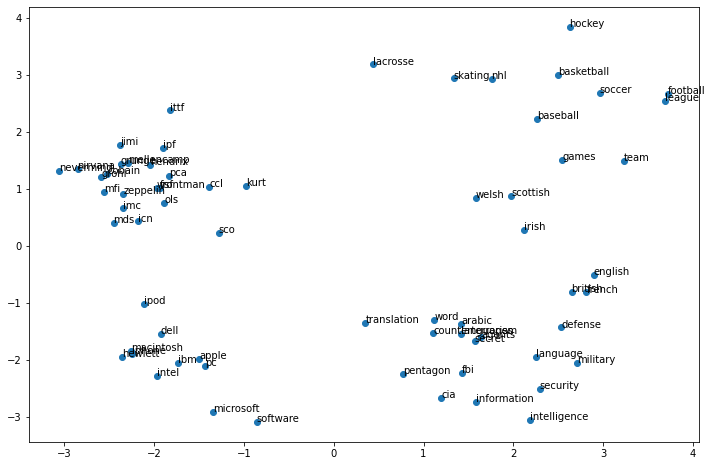

In [14]:
# Linear dimensionality reduction using principle component analysis

from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Reduce down to 2 dimensions
pca.fit(embeddings_df)
emb_pca = pd.DataFrame(pca.transform(embeddings_df), index=embeddings_df.index)

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.scatter(emb_pca.iloc[:,0], emb_pca.iloc[:,1])
for i, txt in enumerate(emb_pca.index):
    ax.annotate(txt, (emb_pca.iloc[i,0], emb_pca.iloc[i,1]))

The word vectors can now be represented in 2d space, as shown above. The reduction seems to have kept the appropriate spacing for the embeddings, as similar words are close together and non-similar words are further apart. There are some outliers, like "english" being closer to "defense" than "irish" or "scottish". I suspect the reason for this has to do with the initial model training and the use of "english" in phrases that discuss politics.

/Users/samquist/miniconda3/envs/563/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/samquist/miniconda3/envs/563/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


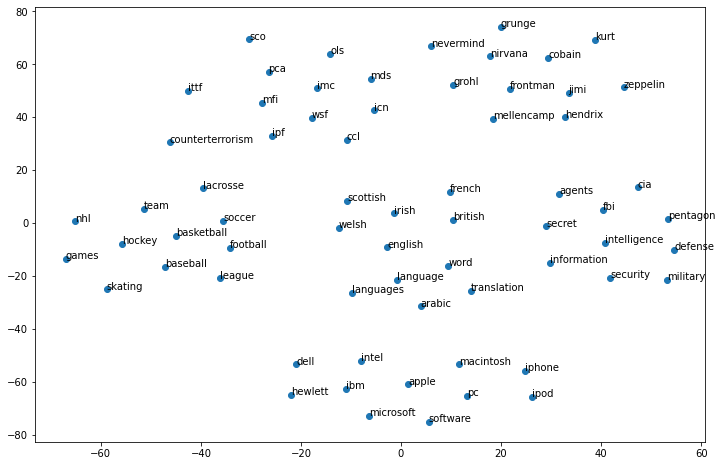

In [15]:
# Non-linear reduction using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2) # Reduce down to 2 dimensions
tsne_df = pd.DataFrame(tsne.fit_transform(embeddings_df), index=embeddings_df.index)

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.scatter(tsne_df.iloc[:,0], tsne_df.iloc[:,1])
for i, txt in enumerate(tsne_df.index):
    ax.annotate(txt, (tsne_df.iloc[i,0], tsne_df.iloc[i,1]))

The groups in t-SNE appear to be more evenly spaced, and the groups can easily been seen. For example, there is a software group, a musical artist group and a sports group while in the PCA plot the groups are not uniformly spaced. Furthermore, the PCA plot has numerous data points that are in-between groups or not in the most sensible group. For example, Welsh, Irish and Scottish are closer to "games" than "English". This representation is due to the distance between words being proportionate to the probability that the words are related, which is how the t-SNE algorithm reduces dimensionality.

<br><br>

## Stereotypes and biases in word embeddings
<hr>

Stereotypes and biases in natural language processing can cause many issues, like discrimination in job applicants due to specific language used on a resume. This next section will explore biases that are still present despite the pre-trained embeddings being de-biased.

### Exploring existing stereotypes and biases in embeddings


An example of using word analogies to explore biases and stereotypes.

In [18]:
# Create function for analogy comparison
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

#### Analogy biases

In [19]:
analogy("man", "doctor", "woman")

man : doctor :: woman : ?


,Analogy word,Score
0,nurse,0.773523
1,physician,0.718943
2,doctors,0.682433
3,patient,0.675068
4,dentist,0.672603
5,pregnant,0.664246
6,medical,0.652045
7,nursing,0.645348
8,mother,0.639333
9,hospital,0.638750


Notice the bias that "woman" corresponds with "nurse" more than "doctor" given that "man" is correlated to "doctor".

In [22]:
analogy("man", "smart", "woman")

man : smart :: woman : ?


,Analogy word,Score
0,intelligent,0.654885
1,sexy,0.597897
2,sophisticated,0.574362
3,mom,0.557256
4,cute,0.549813
5,kids,0.540299
6,pretty,0.530862
7,savvy,0.530233
8,innovative,0.530197
9,attractive,0.528517


Here is another example of analogy bias, where this time the first suggestion is not as biased as the previous example. The difference here is the second suggestion, which implies that "man" is to "smart" as "woman" is to "sexy". 

In [25]:
analogy("man", "strong", "woman")

man : strong :: woman : ?


,Analogy word,Score
0,stronger,0.726966
1,weak,0.657428
2,robust,0.644944
3,strongest,0.634013
4,despite,0.631509
5,support,0.627726
6,growing,0.625404
7,concern,0.605287
8,particularly,0.603681
9,reflected,0.600039


This final analogy example shows again that the first suggestion is not terrible in terms of discrimination or showing bias, but the second and following suggestions are. 

#### Similarity bias

In [16]:
print(glove_wiki_vectors.similarity("white", "poor"))
print(glove_wiki_vectors.similarity("black", "poor"))

0.4408384
0.50771147


Here we can see that the model is biased when it comes to showing similarity scores, as according to the embeddings, "black" is more similar to "poor" than "white" is. 

In [23]:
print(glove_wiki_vectors.similarity("man", "rich"))
print(glove_wiki_vectors.similarity("woman", "rich"))

0.46977922
0.3507729


Once again the model shows bias when two groups are compared to a single descriptive property.

In [24]:
print(glove_wiki_vectors.similarity("man", "kind"))
print(glove_wiki_vectors.similarity("woman", "kind"))

0.6737176
0.5527537


Our model seems to have some quantifiable issues here when in comes to innate bias. All 3 adjectives were picked because they are neutral descriptors, with no underlying assumptions for uses. Despite this neutrality the model shows a bias towards "man" over "woman", and "white" over "black". This can cause a number of issues were this model to be used in commercial or public setting, as those groups that are discriminated against right now would continue to be discriminated against due to the model. Some solutions for this issue could be manually adjusting the embedding values, setting a similarity threshold that eliminates the difference between similarity or analogy values, or using the model in areas where these biases would not have any effect on those that are shown to be discriminated against. I am not a domain expert so the last suggestion may be impossible in practice.

<br><br>

## Building new embeddings, comparing Word2Vec and fastText
<hr>

Here I will compare how the popular NLP models `Word2Vec` and `fastText` handle making new word embeddings. The training corpus I will use is a small subset of a corpus of [biomedical abstracts downloaded from PMC](https://www.kaggle.com/cvltmao/pmc-articles?select=a_b.csv). The objective here is to see how each model picks up new words that have not been seen before and 

In [17]:
df = pd.read_csv("a_b.csv")
df = df.dropna()
df_subset = df.sample(5000, random_state=42)

In [18]:
df_subset.head()

,article_id,abstract
129637,PMC3537527,"Esophageal squamous cell carcinoma (ESCC) shows a 5-year survival rate below 10%, demonstrating the urgency in improving its treatment. Alterations in epidermal growth factor receptors are closely related to malignancy transformation in a number of tumors and recent successful targeted therapies have been directed to these molecules. Therefore, in this study, we analyzed the expression of EGFR and HER2 and evaluated mutation profile as well as the presence of mutations in hotspots of and in ESCC patients. We performed RT-qPCR, immunohistochemistry and Fluorescent hybridization to determine EGFR and HER2 expression in ESCC patients, and direct sequencing and PCR-RFLP for mutations and polymorphism analysis Our results showed an increased mRNA expression in tumors compared to surrounding tissue (p <0.05), with 11% of the cases presenting at least a four-fold difference between tumor and paired adjacent mucosa. EGFR protein overexpression was present only in 4% of the cases. The median expression of mRNA was not different between tumors and adjacent mucosa. Still, 7% of the tumors presented at least a 25-fold higher expression of this gene when compared to its paired counterpart. Immunohistochemical analysis revealed that 21% of the tumors were positive for HER2 (scores 2+ and 3+), although only 3+ tumors presented amplification of this gene. Mutation analysis for (exons 18-21), (codons 12 and 13) and (V600E) showed no mutations in any of the hotspots of these genes in almost 100 patients analyzed. presented synonymous polymorphisms at codon 836 (C>T) in 2.1% of the patients, and at codon 787 (G>A) in 79.2% of the cases. This last polymorphism was also evaluated in 304 healthy controls, which presented a similar frequency (73.7%) in comparison with ESCC patients. The absence of mutations of , and as well as the overexpression of EGFR and HER2 in less than 10% of the patients suggest that this signaling pathway is altered in only a small proportion of patients with ESCC. HER receptors target therapies may have the potential to be effective in only a minor fraction of patients with ESCC."
234041,PMC2711088,"Asthma is the most common chronic disease in childhood, characterized by chronic airway inflammation. There are problems with the diagnosis of asthma in young children since the majority of the children with recurrent asthma-like symptoms is symptom free at 6 years, and does not have asthma. With the conventional diagnostic tools it is not possible to differentiate between preschool children with transient symptoms and children with asthma. The analysis of biomarkers of airway inflammation in exhaled breath is a non-invasive and promising technique to diagnose asthma and monitor inflammation in young children. Moreover, relatively new lung function tests (airway resistance using the interrupter technique) have become available for young children. The primary objective of the ADEM study (Asthma DEtection and Monitoring study), is to develop a non-invasive instrument for an early asthma diagnosis in young children, using exhaled inflammatory markers and early lung function measurements. In addition, aetiological factors, including gene polymorphisms and gene expression profiles, in relation to the development of asthma are studied. A prospective case-control study is started in 200 children with recurrent respiratory symptoms and 50 control subjects without respiratory symptoms. At 6 years, a definite diagnosis of asthma is made (primary outcome measure) on basis of lung function assessments and current respiratory symptoms ('golden standard'). From inclusion until the definite asthma diagnosis, repeated measurements of lung function tests and inflammatory markers in exhaled breath (condensate), blood and faeces are performed. The study is registered and ethically approved. This article describes the study protocol of the ADEM study. The new diagnostic techniques applied in this study could 

In [23]:
import nltk
nltk.download('stopwords')
from preprocessing import MyPreprocessor

corpus = df_subset["abstract"].tolist()
sentences = MyPreprocessor(corpus)  # memory friendly iterator

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samquist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<br><br>

###  Training `Word2Vec` and `fastText`

In [24]:
from gensim.models import FastText, Word2Vec

In [25]:
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2) # Keep hyperparameters the same

In [27]:
model2 = FastText(sentences=sentences, vector_size=100, window=5, min_count=2) # Keep hyperparameters the same

### Comparison

In [36]:
len(model.wv), len(model2.wv) # Comparing vocabulary size

(29910, 29910)

In [60]:
model.wv.most_similar('human')

[('usp39', 0.9350709319114685),
 ('brain', 0.9265483617782593),
 ('stem', 0.9031318426132202),
 ('carcinogenesis', 0.8986384868621826),
 ('angiogenesis', 0.8955050110816956),
 ('osteoblast', 0.8941336870193481),
 ('regenerate', 0.8931884169578552),
 ('androgen', 0.890606164932251),
 ('suppressor', 0.890519380569458),
 ('epithelial-to-mesenchymal', 0.8901906609535217)]

In [61]:
model2.wv.most_similar('human')

[('human-to-human', 0.9870601892471313),
 ('hu', 0.961590588092804),
 ('human–animal', 0.9566490650177002),
 ('human-made', 0.9499544501304626),
 ('hub', 0.9273300170898438),
 ('carcinogenic', 0.9273297786712646),
 ('humans', 0.9271357655525208),
 ('tumorigenic', 0.925788164138794),
 ('cancellous', 0.9124723076820374),
 ('nonhuman', 0.9113366603851318)]

The vectors created are weighed quite differently, as the word2vec model compares _human_ to various medical words, while the fastText model compares _human_ to other words containing "human". This makes sense as fastText breaks down words into smaller components and then creates embeddings for each component as opposed to word2vec which takes the entire word to create an embedding for.

<br><br>

### Unknown words 

Below are some words that are not included in general pre-trained word embedding models as they are not common/new to the general vocabulary. I will compare how each model either contains or doesn't contain a vector representation for each word and I predict that the fastText model will perform better due to the word breakdown that occurs before word embedding in the model.

In [62]:
test_words = [
    "covididiot",
    "fomo",
    "frenemies",
    "anthropause",
    "photobomb",
    "selfie",
    "pxg",  # Abbreviation for pseudoexfoliative glaucoma
    "pacg",  # Abbreviation for primary angle closure glaucoma
    "cct",  # Abbreviation for central corneal thickness
    "escc",  # Abbreviation for esophageal squamous cell carcinoma
]

In [64]:
for word in test_words:
    try:
        model.wv['{}'.format(word)]
        invec = True
    except Exception:
        invec = False
    print("%s is in word2vec model: %r" % (word, invec))
    print("%s is in fastText model: %r \n" % (word, word in model2.wv))

covididiot is in word2vec model: False
covididiot is in fastText model: True 

fomo is in word2vec model: False
fomo is in fastText model: True 

frenemies is in word2vec model: False
frenemies is in fastText model: True 

anthropause is in word2vec model: False
anthropause is in fastText model: True 

photobomb is in word2vec model: False
photobomb is in fastText model: True 

selfie is in word2vec model: False
selfie is in fastText model: True 

pxg is in word2vec model: True
pxg is in fastText model: True 

pacg is in word2vec model: True
pacg is in fastText model: True 

cct is in word2vec model: True
cct is in fastText model: True 

escc is in word2vec model: True
escc is in fastText model: True 



We can see above that all the medical abbreviations are present in the word2vec vocab, but the neolisms are not. In the fastText model, all of the words tested were in the vocabulary as fastText creates mini embeddings from larger words. This can be helpful in instances where the context of a broken-down word keeps its meaning, but in more general applications I would not want mini embeddings created as they would not carry the same sentiment and meaning as the entire word.